In [1]:
import pandas as pd
import numpy as np
import warnings
from sklearn import model_selection
from sklearn.neighbors import KNeighborsRegressor
from keras.layers import Dense, Activation, Dropout
from keras.layers import LSTM
from keras.models import Sequential
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error
warnings.filterwarnings("ignore") # Hide messy Numpy warnings

Using TensorFlow backend.


**Load and preprocessing data:  
Strings like 'residential' from 'property_type' feature was transformed to numbers. All the values are normalize to [0,1] range (this helps when using Sigmoid as an output activation function). The 1st feature 'apn' has many unique numbers (almost all of them) so I decided to drop it to avoid decorrelation.**

In [15]:
def load_preprocessing(path):   
    ### load and preprocessing
    df = pd.read_csv(path, delimiter = ',')

    # var_1
    zip_code = df['zip_code'].values
    for i,codes in enumerate(zip_code):
        if len(str(codes)) > 5:
            zip_code[i] = codes[0:5]

    zip_code = zip_code.astype(float)    

    # var_2
    property_type = df['property_type'].values
    for i, j in enumerate(property_type):
        if j == 'residential':
            property_type[i] = 1
        if j == 'lease':
            property_type[i] = 2
        if j == 'residential income':
            property_type[i] = 3
    property_type = property_type.astype(float)

    # var_3_4_5_6_7
    lot = df['lot'].values.astype(float)
    sqft = df['sqft'].values.astype(float)
    beds = df['beds'].values.astype(float)
    baths = df['baths'].values.astype(float)
    price = df['price'].values.astype(float)

    # feature dataset
    data = [zip_code, property_type, lot, sqft, beds, baths, price]
    nb_features = len(data) - 1

    # normalize data
    scaler = MinMaxScaler(feature_range=(0, 1))
    for i in range(len(data)):
        data[i] = data[i][0:50000]
        data[i] = scaler.fit_transform(data[i]) 

    data_DNN = [[]] * len(data[0])
    for j in range(len(data[0])):
        data_DNN[j] = [data[i][j] for i in range(len(data)) ]

    data_DNN = np.array(data_DNN)  
    row = round(0.7 * data_DNN.shape[0])
    train   = data_DNN[:int(row), :]
    x_train = train[:, :-1]
    y_train = train[:, -1]
    x_test  = data_DNN[int(row):, :-1]
    y_test  = data_DNN[int(row):, -1]
    
    return x_train, y_train, x_test, y_test, nb_features, scaler

**I'm using Deep Neural Networks as the 2nd prediction model. I didn't had time to appropriately fine tunning the model so it is expected better results than showed in here**

In [16]:
# layers = [features, hidden_neurons, output]
def DNN_model(layers):
    # create model
    model = Sequential()
    model.add(Dense(layers[1], input_dim = layers[0], activation='relu'))
    model.add(Dense(layers[1], activation='relu'))
    model.add(Dense(layers[2], activation='sigmoid'))
    # Compile model
    model.compile(loss='mae', optimizer='rmsprop')
    
    return model

def predict_point_by_point(model, data):
    #Predict each timestep given the last sequence of true data, in effect only predicting 1 step ahead each time
    predicted = model.predict(data)
    predicted = np.reshape(predicted, (predicted.size,))
    return predicted

# score metrics
def score_metrics(y_true, y_pred): 
    # metrics
    mae = mean_absolute_error(y_true, y_pred)
    
    return mae

**I'm using matplotlib to show the predictions on the deep learning model (model_2).**

In [17]:
from matplotlib import pyplot as plt

def plot_results(predicted_data, true_data):
    plt.plot(true_data)
    plt.plot(predicted_data)
    plt.title('model predictions')
    plt.ylabel('Price')
    plt.xlabel('X_axis')
    plt.legend(['True Data', 'Prediction'], loc='upper left')
    plt.show()


**This '__main__' cell will run and show the results of both models. Just pay attention on the output prints to see the results provided by 'Mean Absolute Error'. I'm avoiding 'Mean Absolute Percentage Error' here because this method have high chances to produce division by zeros.**

Mean Absolute Error of the KNeighborsRegressor Model:  0.0018
MAE:  0.0018
Train on 31500 samples, validate on 3500 samples
Epoch 1/10
31500/31500 [==============================] - 1s - loss: 0.0890 - val_loss: 0.0044

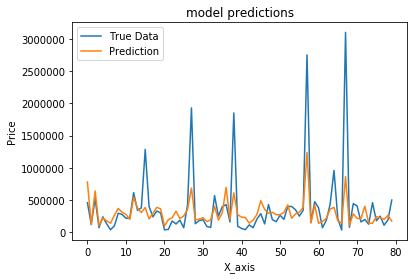

In [18]:
# Main Run Thread
if __name__=='__main__':
    
    # config
    path = '/home/teresas/notebooks/deep_learning/time_series/files/properties.csv'
    epochs  = 10
    
    ### load and preprocessing data
    x_train, y_train, x_test, y_test, nb_features, scaler = load_preprocessing(path)
    
    # model_1: KNeighborsRegressor
    model_1 = KNeighborsRegressor()
    model_1.fit(x_train, y_train)  
    predicted = predict_point_by_point(model_1, x_test)  
    mae = score_metrics(y_test, predicted)
    print('Mean Absolute Error of the KNeighborsRegressor Model: ',round(mae, 4))
    print('MAE: ',round(mae, 4))
    
    # model_2: Deep Learning Model Using DNNs
    # layers = [features, hidden_neurons, output]
    model = DNN_model([nb_features, 150, 1])
    model.fit(x_train, y_train, batch_size = 512, nb_epoch = epochs, validation_split = 0.1)
    predicted = predict_point_by_point(model, x_test) 
    mae = score_metrics(y_test, predicted)
    print('Mean Absolute Error of the Deep Learning Model Using DNNs: ',round(mae, 4))
    print('MAE: ',round(mae, 4))
    # inverse normalization to plot results
    real = scaler.inverse_transform(y_test)  
    pred = scaler.inverse_transform(predicted)  
    # plot results (1st 100 points)
    print('Plot Partial Results of the Deep Learning Model Using DNNs')
    plot_results(pred[60:140], real[60:140])

![](/home/teresas/Downloads/sp500.jpeg)